# Project 2: Graph Mining
*Due Wednesday November 14th, 2018 at 11:59 pm*  
*Notebook Author: Koki Sasagawa*

## Task 1:
Link Predction - incomplete social network that contains some large number of edges removed. Task is to predict up to 50000 edges that system predicts to be most likely. 

## Submission
**Link prediction** should be a text file with two items on each line: node1 and node2  
The first 50000 most likely links will be produced and submitted. 

## Running the notebook
If the adjacnecy list file has already been provided run this notebook. Otherise, run the `data_preparation.ipynb` notebook first. 

Also require `fastlp.py` file to be in the same directory for bounded link predicton algorithms and `decorators` to measure function runtime.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastlp
from decorators import timer
%matplotlib inline

## 1. Read the adjacency list file and create a dictionary

In [2]:
adj_list = {}

with open('../data/adjacency_list.txt', 'r') as f:
    for line in f:
        adj_list[line.split(',')[0]] = line.split(',')[1].rstrip().split(' ')

## 2. Prepare functions for link predictions with common neighbors filtering

The following 5 functions (filter_by_lemma1, invert_adjacency_list, generate_accompanied_groups, filter_by_lemma2, generate_node_pairs) were created using the following paper as a reference:

Cui W, Pu C, Xu Z, Cai S, Yang J, Michaelson A. Bounded link prediction in very large networks. Physics A: Statistical Mechanics and its Applications. 2016;457:202-214. doi:https://doi.org/10.1016/j.physa.2016.03.041.

In [3]:
# Add timer decorator to measure runtime 
filter_by_lemma1 = timer(fastlp.filter_by_lemma1)
invert_adjacency_list = timer(fastlp.invert_adjacency_list)
generate_accompanied_groups = timer(fastlp.generate_accompanied_groups)
filter_by_lemma2 = timer(fastlp.filter_by_lemma2)
generate_node_pairs = timer(fastlp.generate_node_pairs)

## 3. Find Optimal L value 

To determine which threshold L to use to filter nodes, plot the change in number of nodes in response to L. 

In [4]:
# Threshold - from 5 to 100 (increments of 5)
# Count number of node pairs that are above the threshold 
results = {}

for L in range(0, 150, 1):
    count = 0
    for k, v in adj_list.items():
        if len(v) > L:
            count += 1
    results[L] = count  

In [5]:
node_count = pd.DataFrame.from_dict({'L':list(results.keys()), 'node_count': list(results.values())})

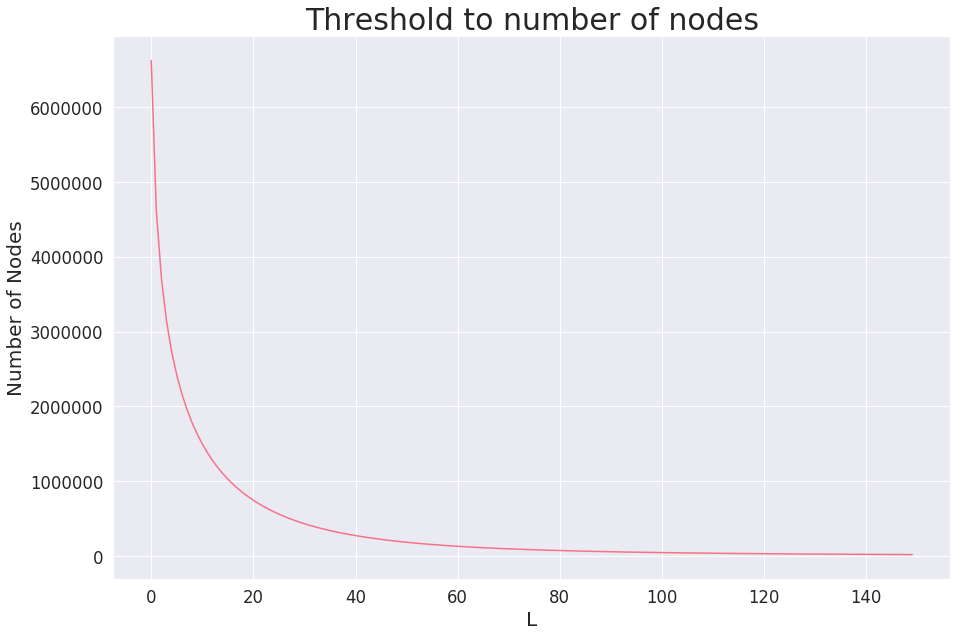

In [6]:
# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,10))

# Create plot
g = sns.lineplot(x='L', y='node_count', markers=True, data=node_count)

# Add plot labels 
g.set_xlabel('L', fontsize=20)
g.set_ylabel('Number of Nodes', fontsize=20)
g.axes.set_title('Threshold to number of nodes', fontsize=30)

plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./{}.png'.format('threshold_vs_node_count'))

Select L=50 to be my threshold as that is where the curve begins to flatten and the number of nodes begins to stable out.

## 4. Generate candidate node pairs

In [8]:
# Define Threshold
L = 50

# Generate candidate pairs
filtered_adj_list = filter_by_lemma1(adj_list, L)
inverted_adj_list = invert_adjacency_list(filtered_adj_list)
filtered_adj_list = None
acc_groups = generate_accompanied_groups(inverted_adj_list)
filtered_acc_groups = filter_by_lemma2(acc_groups, L)
acc_groups = None
candidate_node_pairs = generate_node_pairs(filtered_acc_groups, inverted_adj_list, L)
filtered_acc_groups = None
inverted_adj_list = None

print("Candidate node pairs generated!")

Running filter_by_lemma1...
Finished in 0.9893s
Running invert_adjacency_list...
Finished in 16.6541s
Running generate_accompanied_groups...
Finished in 11.6141s
Running filter_by_lemma2...
Finished in 0.0687s
Running generate_node_pairs...
Finished in 367.3262s
Candidate node pairs generated!


## 5. Save candidate nodes as csv file

In [9]:
with open('../data/candidate_pairs.csv', "w") as f:
    f.write('node1,node2,CN\n')
    for i in candidate_node_pairs:
        f.write('{}, {}, {}\n'.format(i[0][0], i[0][1], i[1]))

## 6. Predict new links

Resulting nodes are the node pairs that have common neighbors above a certain threshold. From this list, find the top 50000 most likely pairs that are not already connected. 

In [3]:
candidate_nodes = pd.read_csv('../data/candidate_pairs.csv',
                              dtype={'node1': np.int32, 'node2': np.int32, 'CN': np.int32})

print('Rows: {}'.format(candidate_nodes.shape[0]))
candidate_nodes.head()

Rows: 231167


,node1,node2,CN
0,1091804,967845,67
1,1091804,1354523,51
2,1091804,2309755,68
3,4573414,967845,101
4,4573414,1354523,54


In [4]:
candidate_nodes.sort_values('CN', inplace=True, ascending=False)
candidate_nodes.head()

,node1,node2,CN
140294,6247815,1542000,593
123751,5401224,988315,557
3661,304552,6314086,545
123761,5401224,885348,521
123748,5401224,4930496,509


In [5]:
@timer
def link_prediction(c_pairs, adj_list, limit):
    '''Infer the most likely links between nodes in static network

    This function infers the mostly likely links between nodes
    based on the number of common neighbors.

    :params c_pairs: candidate node pairs
    :type c_pairs: pandas dataframe
    :params adj_list: adjacency list
    :type adj_list: dict of {int : list of int}
    :params limit: limit number of results returned
    :type limit: int
    :returns: predicted links between nodes
    :rtype: list of tuple of (int, int)
    '''

    predictions = []

    count = 0

    for r in c_pairs.itertuples():
        if count < limit:
            # keys in the adj_list dict are string type
            if str(r[2]) in adj_list.get(str(r[1])):
                continue
            else:
                predictions.append((r[1], r[2]))
                count += 1

    return predictions

In [6]:
predicted_links = link_prediction(candidate_nodes, 
                                  adj_list, 
                                  50000)

Running link_prediction...
Finished in 1.2624s


## 10. Save link predictions as txt file

In [7]:
with open('../data/predicted_links.txt', "w") as f:
    for i in predicted_links:
        f.write('{} {}\n'.format(i[0], i[1]))